<a href="https://colab.research.google.com/github/DGuilherme/PMTese/blob/main/Turbofan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [35]:
#import

# Install any missing libraries
!pip install tensorflow

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Data load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [31]:

# Load the dataset
# /content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/train_FD001.txt
train_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/train_FD001.txt/train_FD001.txt', delim_whitespace=True, header=None)
test_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/test_FD001.txt/test_FD001.txt', delim_whitespace=True, header=None)
rul_data = pd.read_csv('/content/drive/MyDrive/Python/predictive-maintenance-main/datasets/cmapss/RUL_FD001.txt/RUL_FD001.txt', delim_whitespace=True, header=None)

column_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 22)]

train_data.columns = column_names
test_data.columns = column_names
rul_data.columns = ['RUL']



In [22]:
# Display the first few rows of the training data
print(train_data.head())

# Check the shape of the data
print(f"Training Data Shape: {train_data.shape}")
print(f"Test Data Shape: {test_data.shape}")
print(f"RUL Data Shape: {rul_data.shape}")

# Check for missing values
print(train_data.isnull().sum())
print(test_data.isnull().sum())


   id  cycle  setting1  setting2  setting3  sensor1  sensor2  sensor3  \
0   1      1   -0.0007   -0.0004     100.0   518.67   641.82  1589.70   
1   1      2    0.0019   -0.0003     100.0   518.67   642.15  1591.82   
2   1      3   -0.0043    0.0003     100.0   518.67   642.35  1587.99   
3   1      4    0.0007    0.0000     100.0   518.67   642.35  1582.79   
4   1      5   -0.0019   -0.0002     100.0   518.67   642.37  1582.85   

   sensor4  sensor5  ...  sensor14  sensor15  sensor16  sensor17  sensor18  \
0  1400.60    14.62  ...   8138.62    8.4195      0.03       392      2388   
1  1403.14    14.62  ...   8131.49    8.4318      0.03       392      2388   
2  1404.20    14.62  ...   8133.23    8.4178      0.03       390      2388   
3  1401.87    14.62  ...   8133.83    8.3682      0.03       392      2388   
4  1406.22    14.62  ...   8133.80    8.4294      0.03       393      2388   

   sensor19  sensor20  sensor21  sensor22  sensor23  
0     100.0     39.06   23.4190       

In [19]:
print(train_data.describe())


                 id         cycle      setting1      setting2  setting3  \
count  20631.000000  20631.000000  20631.000000  20631.000000   20631.0   
mean      51.506568    108.807862     -0.000009      0.000002     100.0   
std       29.227633     68.880990      0.002187      0.000293       0.0   
min        1.000000      1.000000     -0.008700     -0.000600     100.0   
25%       26.000000     52.000000     -0.001500     -0.000200     100.0   
50%       52.000000    104.000000      0.000000      0.000000     100.0   
75%       77.000000    156.000000      0.001500      0.000300     100.0   
max      100.000000    362.000000      0.008700      0.000600     100.0   

        sensor1       sensor2       sensor3       sensor4       sensor5  ...  \
count  20631.00  20631.000000  20631.000000  20631.000000  2.063100e+04  ...   
mean     518.67    642.680934   1590.523119   1408.933782  1.462000e+01  ...   
std        0.00      0.500053      6.131150      9.000605  1.776400e-15  ...   
min 

In [23]:
print(rul_data)

    RUL  IGNORE
0   112     NaN
1    98     NaN
2    69     NaN
3    82     NaN
4    91     NaN
..  ...     ...
95  137     NaN
96   82     NaN
97   59     NaN
98  117     NaN
99   20     NaN

[100 rows x 2 columns]


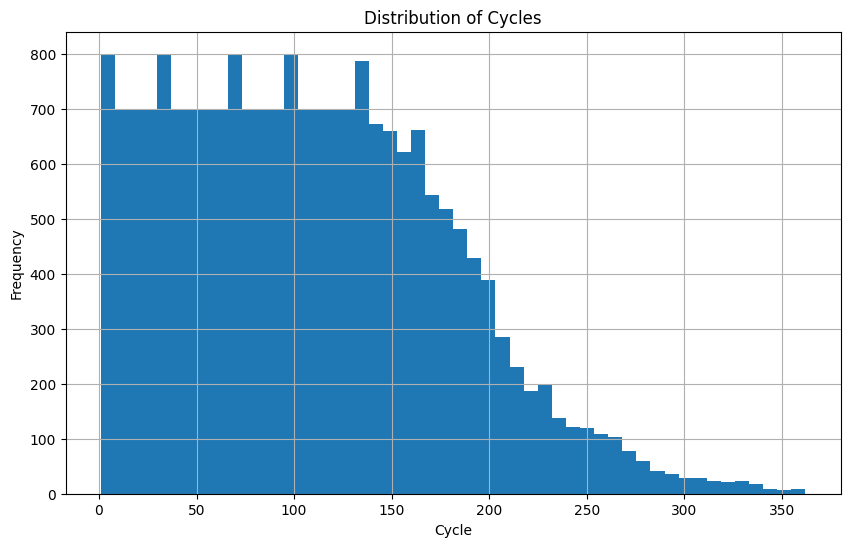

In [24]:
plt.figure(figsize=(10, 6))
train_data['cycle'].hist(bins=50)
plt.xlabel('Cycle')
plt.ylabel('Frequency')
plt.title('Distribution of Cycles')
plt.show()


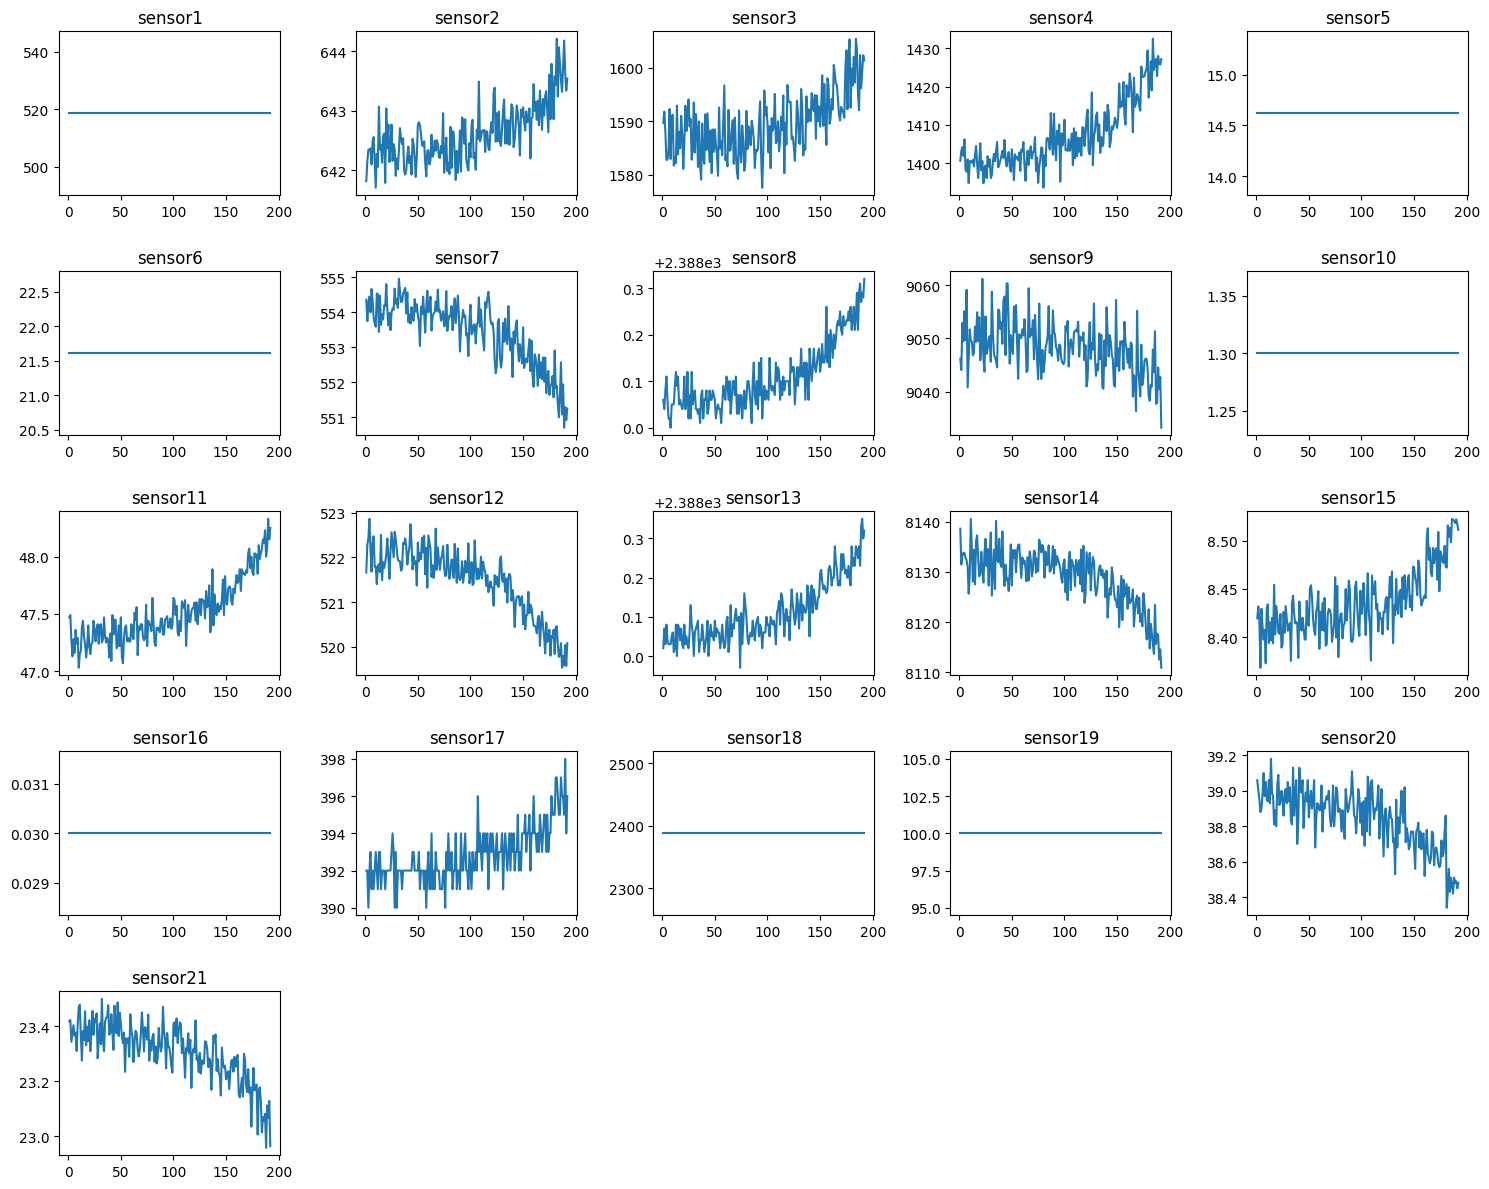

In [32]:
engine_id = 1
engine_data = train_data[train_data['id'] == engine_id]

plt.figure(figsize=(15, 12))
for i in range(5, train_data.shape[1]):
    plt.subplot(5, 5, i-4)
    plt.plot(engine_data['cycle'], engine_data.iloc[:, i])
    plt.title(train_data.columns[i])
plt.tight_layout()
plt.show()


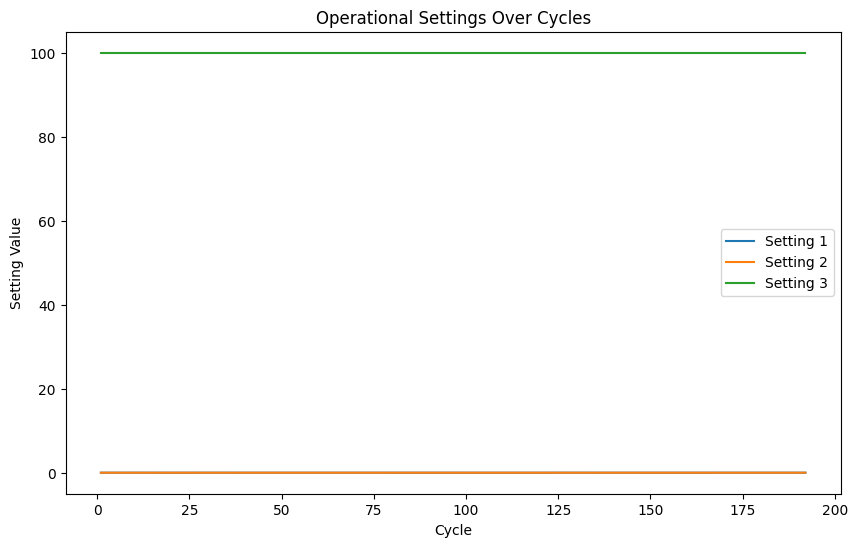

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(engine_data['cycle'], engine_data['setting1'], label='Setting 1')
plt.plot(engine_data['cycle'], engine_data['setting2'], label='Setting 2')
plt.plot(engine_data['cycle'], engine_data['setting3'], label='Setting 3')
plt.xlabel('Cycle')
plt.ylabel('Setting Value')
plt.title('Operational Settings Over Cycles')
plt.legend()
plt.show()


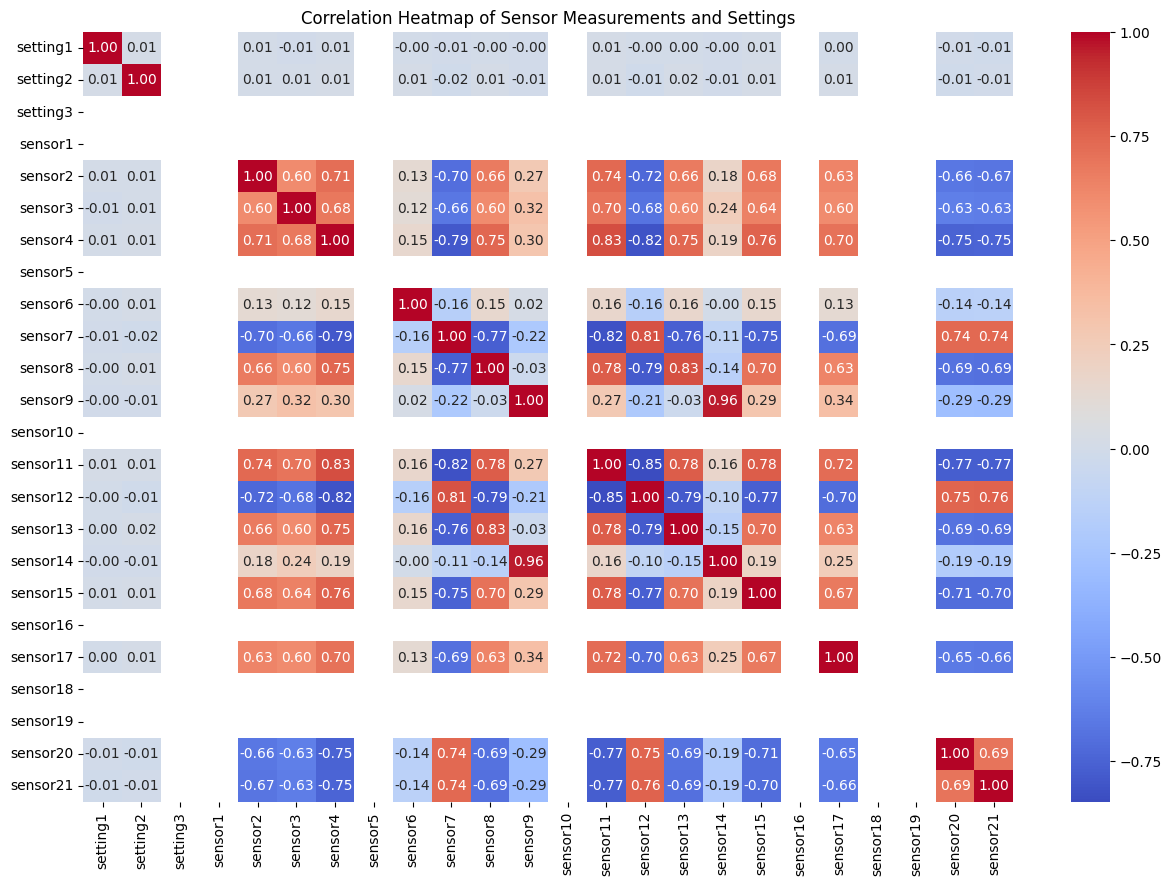

In [36]:
plt.figure(figsize=(15, 10))
sns.heatmap(train_data.iloc[:, 2:].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Sensor Measurements and Settings')
plt.show()


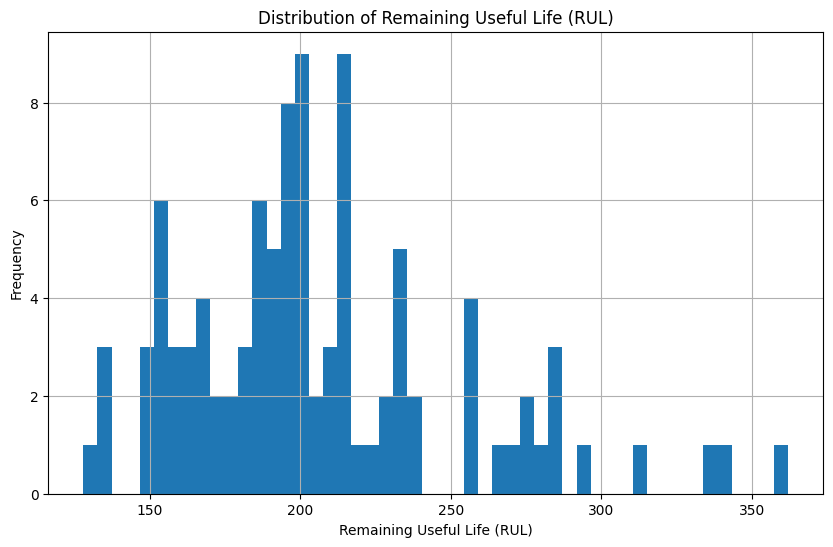

In [37]:
# Calculate RUL for the training data
train_rul = train_data.groupby('id')['cycle'].max().reset_index()
train_rul.columns = ['id', 'max_cycle']
train_rul['RUL'] = train_rul['max_cycle']

plt.figure(figsize=(10, 6))
train_rul['RUL'].hist(bins=50)
plt.xlabel('Remaining Useful Life (RUL)')
plt.ylabel('Frequency')
plt.title('Distribution of Remaining Useful Life (RUL)')
plt.show()
